In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
with open(f'{configs.engram_dir}02_gamma_v_rsteps/results.p', 'rb') as f:
    results = pickle.load(f)

In [3]:
for key in results.keys():
    results[key] = np.array(results[key])

In [7]:
results.keys()

dict_keys(['gamma_axes', 'rstep_axes', 'nonlinearities', 'vals'])

In [8]:
results['vals']

array([0.02549756, 0.02857045, 0.02657122, 0.02837744, 0.02623633,
       0.03104773, 0.02650606, 0.02896995, 0.02638687, 0.02852927,
       0.02385785, 0.02676698, 0.02916643, 0.03450446, 0.02551264,
       0.03064488, 0.02517636, 0.02839256, 0.06060501, 0.05484747,
       0.05758513, 0.0598549 , 0.06083674, 0.06627902, 0.06850684,
       0.07367246, 0.06168136, 0.07654177, 0.04902544, 0.06942745,
       0.06214961, 0.07041147, 0.06173225, 0.07076852, 0.0615513 ,
       0.06428737, 0.14222283, 0.15593348, 0.15531572, 0.14553048,
       0.16760893, 0.1498688 , 0.16932424, 0.17118744, 0.1653551 ,
       0.18330688, 0.17082381, 0.189093  , 0.18110313, 0.19570542,
       0.16962805, 0.20143718, 0.17934586, 0.19276185])

In [9]:
nonlinearities = results['nonlinearities']
gammas = results['gammas']
rsteps = results['rsteps']
M_maes = results['M_maes']
T_maes = results['T_maes']

In [11]:
xs = np.sort(np.unique(results['gammas']))
ys = np.sort(np.unique(results['rsteps']))

## Plot test loss for different gammas and recurrent steps

None


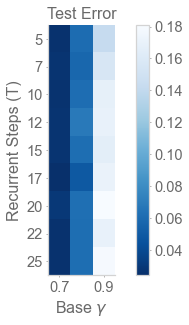

relu


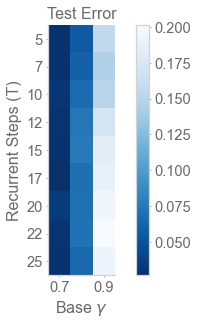

In [18]:
for nonlinearity in np.unique(nonlinearities):
    print(nonlinearity)
    mat = np.zeros((xs.size, ys.size))*np.nan
    for x_idx, x in enumerate(xs):
        for y_idx, y in enumerate(ys):
            idxs = np.logical_and(
                gammas==x, nonlinearities==nonlinearity
                )
            idxs = np.logical_and(rsteps==y, idxs)
            vals = M_maes[idxs]
            mat[x_idx][y_idx] = np.mean(vals)
        
    plt.figure(figsize=(6.4, 4.8))
    plt.imshow(mat.T, cmap="Blues_r", vmax=3., aspect=1.25)
    plt.yticks(np.arange(ys.size), ys)
    plt.xticks([0, xs.size-1], [xs[0], xs[-1]])
    plt.ylabel('Recurrent Steps (T)')
    plt.xlabel('Base $\gamma$')
    plt.colorbar()
    plt.title("Test Error")
    plt.tight_layout()
    plt.savefig(f"gamma_v_rsteps_{nonlinearity}.png", dpi=300)
    plt.show()